#Loading of principal libraries that will be used for analysis

In [44]:
#Load libraries
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import textblob

#Initial input from users and scrapper to obtain tweets

In [45]:
#Input Twitter account to review
query_account = input("Input the twitter account you wish to review replied comments for sentiment analysis")
query_limit = int(input("How many comments would you like to review? (Note: the larger the limit, the longer it will take to analyze)"))

In [46]:
#Get base information
#Social Media Imports
import snscrape.modules.twitter as sntwitter

#Query and exection
query = f"(to:{query_account}) (@{query_account}) filter:replies"
tweets = []
limits = query_limit

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == limits:
        break
    else: tweets.append(tweet)    

In [47]:
#load imported tweets to pandas
df_corpus = pd.DataFrame(tweets)

df_corpus = df_corpus.drop(columns=['url', 'renderedContent', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 
       'source', 'sourceUrl', 'outlinks', 'tcooutlinks',
       'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
       'inReplyToUser', 'mentionedUsers', 'coordinates', 'place', 'cashtags'], axis=1)

#Add Tweet length
df_corpus['Tweet_LEN']= df_corpus['content'].apply(lambda x: len(x))

#drop all non-english rows and tweets with less than 5 length
df_corpus = df_corpus[df_corpus['lang'] =='en']
df_corpus = df_corpus[df_corpus['Tweet_LEN'] >= 10]


In [48]:
df_corpus.describe()

,id,Tweet_LEN
count,1.706000e+03,1706.000000
mean,1.590819e+18,103.715123
std,6.517078e+13,75.605534
min,1.590725e+18,10.000000
25%,1.590763e+18,47.000000
50%,1.590808e+18,79.000000
75%,1.590862e+18,141.000000
max,1.590993e+18,319.000000


<AxesSubplot: >

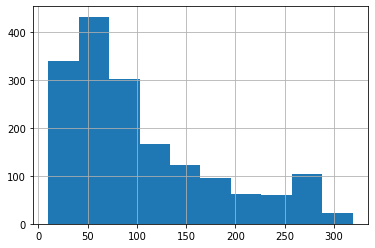

In [49]:
df_corpus.Tweet_LEN.hist()

In [50]:
#create dictionary of locations from user:
df_loc = df_corpus['user'].to_dict()

#create empty list
df_locations =[]

#Add user locations to df_locations
for i in df_loc:
    df_locations.append(df_loc[i]["location"])

#Add locations to df_corpus
df_corpus['location'] = df_locations

# VADER sentiment analysis testing

pre-processing pipeline added in order to leave in punctuation so VADER can use it witin the sentiment analysis

In [51]:
# VADER Sentiment analysis - Better analysis for social media as it has more related to puncuation and emojis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# load spacy english large dictionary
nlp = spacy.load('en_core_web_sm')

#Remove Mentions '@' and "#" and URLs from tweets
import re

#Function to remove mentions
def remove_regExp(text):
    text = re.sub('@[\w]+','',text) #remove users
    text = re.sub(r"\S*https?:\S*",'', text) #remove URLs
    text = re.sub('#[\w]+','',text) #remove hastags
    text = re.sub('&','',text) #remove '&'
    return text

#Call function to clean data
df_corpus['content_clean'] = df_corpus['content'].apply(lambda x: remove_regExp(str(x)))



#Function to remove punc, stopwords, spaces, currency
def clean_pipeline_vader(text):
    text = nlp(text)
    output = []
    for token in text:
        if not token.is_stop and not token.is_space and not token.is_currency :         
             output.append(token.lemma_)
    else: return ' '.join(output)


#Call pipeline function to clean data
df_corpus['content_cleanr'] = df_corpus['content_clean'].apply(lambda x: clean_pipeline_vader(x))

#sentiment classification: positive, neutral, negative
def sent_class(num):
    if num> 0:
        return "Positive"
    elif num < 0:
        return "Negative"
    else: return "Neutral"

#Subjectivity classification: Objective, subjective 
def sub_class(num):
    if num > 0:
        return "Subjective"
    else: return "Objective"

#initiate instance
vader = SentimentIntensityAnalyzer()

#VADER sentiment analysis
df_corpus['VADER_Score'] = df_corpus.content_clean.apply(lambda x: vader.polarity_scores(x))

#Vader sentiment score:
df_corpus['VADER_Score'] = df_corpus['VADER_Score'].apply(lambda d: d['compound'])

#Vader sentiment classification:
df_corpus['Vader_Score_Class'] = df_corpus.VADER_Score.apply(sent_class)


# TextBlob sentiment analysis

Pipeline to remove punctuation was added to better optimize TextBlob

In [52]:
#Textblob sentiment analysis
from textblob import TextBlob

#Remove Mentions '@' and "#" and URLs from tweets
import re

def clean_pipeline_TextBlob(text):
    text = nlp(text)
    output = []
    for token in text:
        if not token.is_punct:         
             output.append(str(token))
    else: return ' '.join(output)

#Call function to clean data
df_corpus['content_clean'] = df_corpus['content_clean'].apply(lambda x: clean_pipeline_TextBlob(x))


#make df text

def stirng_setting(text):
    transform = str(text)
    return transform

#sentiment calculation
def senti_calculation(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None


#Subjective or Objective
def subj_calculation(text):
    try:
        return TextBlob(text).subjectivity
    except:
        return None

#Convert content_clean to string format
df_corpus['content_clean'] = df_corpus['content_clean'].apply(stirng_setting)

#Add sentimet score to DF
df_corpus['TextBlob_Sentiment_Score'] = df_corpus['content_clean'].apply(senti_calculation)

#Add sentiment classiification to text
df_corpus['TextBlob_Score_Class'] = df_corpus.TextBlob_Sentiment_Score.apply(sent_class)

#add subjectivity score to dataframe
df_corpus["TextBlob_Subj_Score"] = df_corpus['content_clean'].apply(subj_calculation)

#Add sentiment classiification to text
df_corpus['TextBlob_Subj_Class'] = df_corpus.TextBlob_Subj_Score.apply(sub_class)

# Data Visualization and EDA of the data

<AxesSubplot: >

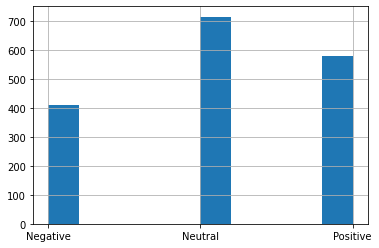

In [53]:
df_corpus['TextBlob_Score_Class'].hist()

<AxesSubplot: >

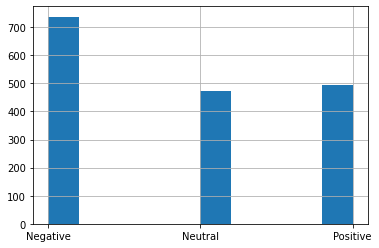

In [54]:
df_corpus['Vader_Score_Class'].hist()

# Topic Modeling with BERTopic
including: Vectorized results, Clustered Model and reduced dimensionality

In [55]:
#BERTopic wtih Vectorized results
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer

ct_model = ClassTfidfTransformer(reduce_frequent_words=True,bm25_weighting=True)
topic_model = BERTopic(ctfidf_model=ct_model)
topics, probs = topic_model.fit_transform(docs)
topic_model.reduce_topics(docs, nr_topics=10)

#get list of topic models
df_names = pd.DataFrame(topic_model.generate_topic_labels(nr_words=5))

#Map Topic models names to coupus
df_corpus["Topics_Vec"] = topic_model.topics_
df_corpus["Topics_Vec_Nr"] = topic_model.topics_
#Get number for each topic and input into dataFrame:
df_corpus['Topics_Vec'] = df_corpus['Topics_Vec'].apply(lambda x: x+1)

df_names_dict = df_names.to_dict()

df_corpus['Topics_Vec'] = df_corpus.Topics_Vec.apply(lambda x: df_names_dict[0][x])

NameError: name 'docs' is not defined

In [ ]:
#BERTopic wtih clustered results
from bertopic import BERTopic
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model_cluster = BERTopic(hdbscan_model=hdbscan_model, nr_topics=10)

topics, probs = topic_model_cluster.fit_transform(docs)

#get list of topic models
df_names_cluster = pd.DataFrame(topic_model_cluster.generate_topic_labels(nr_words=5))

#Map Topic models names to coupus
df_corpus["Topics_Cluster"] = topic_model_cluster.topics_
df_corpus["Topics_Cluster_nr"] = topic_model_cluster.topics_
#Get number for each topic and input into dataFrame:
df_corpus['Topics_Cluster'] = df_corpus['Topics_Cluster'].apply(lambda x: x+1)

df_names_cluster_dict = df_names_cluster.to_dict()

df_corpus['Topics_Cluster'] = df_corpus.Topics_Cluster.apply(lambda x: df_names_cluster_dict[0][x])

In [ ]:
#Bertopic with dementionality reduction

from bertopic import BERTopic
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
topic_model_dim = BERTopic(umap_model=umap_model,nr_topics=10)

topics, probs = topic_model_dim.fit_transform(docs)

#get list of topic models
df_names_dim = pd.DataFrame(topic_model_dim.generate_topic_labels(nr_words=5))

#Map Topic models names to coupus
df_corpus["Topics_Dim"] = topic_model_dim.topics_
df_corpus["Topics_Dim_Nr"] = topic_model_dim.topics_

#Get number for each topic and input into dataFrame:
df_corpus['Topics_Dim'] = df_corpus['Topics_Dim'].apply(lambda x: x+1)

df_names_dim_dict = df_names_dim.to_dict()

df_corpus['Topics_Dim'] = df_corpus.Topics_Dim.apply(lambda x: df_names_dim_dict[0][x])

In [ ]:
#Save dataframe as a CSV
df = df_corpus

#combine all score together of the number topics if =-3, remove
df['total_topics'] = df['Topics_Vec_Nr'] + df['Topics_Cluster_nr']+df['Topics_Dim_Nr']

df=df[df['total_topics']>-3]

#modify the date format 
df['date'] = pd.to_datetime(df['date']).dt.to_period('M')

df.to_csv("C:/Users/Ryanw/Desktop/TFM/Results.csv")